# Epsilon-Greedy for MovieLens 100k Datasaet


### Initialization python envirnment

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt


### Loading the data and define train and test data


In [7]:
item_file = 'ml-100k/u.item'
user_file = 'ml-100k/u.user'
rating_file = 'ml-100k/u.data'

item_cols = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
] + [f'genre_{i}' for i in range(19)]  # 19 genres

rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

items = pd.read_csv(item_file, sep='|', encoding='latin-1', names=item_cols, header=None)
users = pd.read_csv(user_file, sep='|', names=user_cols, header=None)

ratings = pd.read_csv(rating_file, sep='\t', names=rating_cols, header=None)

#  sorting ratings by timestamp before splitting to simulate chronological learning:
ratings = ratings.sort_values(by='timestamp')

ix = int(len(ratings) * 0.8)
train = ratings.iloc[0:ix,:]
test = ratings.iloc[ix:,:]

### Define Arms to be Movie Ids

In [8]:
n_arms = len(ratings['movie_id'].unique()) #1682
unique_arms = ratings['movie_id'].unique()

# Epsilon-Greedy Class

For update:
$$N(a) = N(a) + 1$$
$$ Q(a) = Q(a) + \frac{1}{N(a)} [R - Q(a)] $$

In [9]:
class EpsilonGreedy:
    def __init__(self, arms, epsilon):
        self.arms = arms  # list of movie_ids
        self.epsilon = epsilon
        self.Q = {arm: 1.0 for arm in arms}  # optimistic init, we could initialize with value 0
        self.N = {arm: 0 for arm in arms}

    def select_arm(self):
        if random.random() <= self.epsilon:
            return random.choice(self.arms)
        return max(self.Q, key=self.Q.get)

    def update(self, chosen_arm, reward):
        self.N[chosen_arm] += 1
        n = self.N[chosen_arm]
        self.Q[chosen_arm] += (1 / n) * (reward - self.Q[chosen_arm])

    def average_q(self):
        return statistics.mean(self.Q.values())
        
      

### Offline Training with convergence check

This is offline bandit, we use the logged data to update the epsilon greedy. we do not use select_arm() in offline setting

In [ ]:
epsilon = 0.1
eg = EpsilonGreedy(unique_arms, epsilon)

no_improvement_counter = 0
max_no_improvement = 3  # stop if no change for 3 consecutive epochs


epoch = 0
while True:
    prev_gain = eg.average_q()
    epoch += 1
    print(epoch)
    for i in range(len(train)):
        row = train.iloc[i]
        movie_id = row['movie_id']
        reward = int(row['rating'] >= 4)
                
        eg.update(movie_id, reward)
        
    new_gain = eg.average_q()
    print(abs(new_gain - prev_gain))
    if abs(new_gain - prev_gain) < 0.1:
        no_improvement_counter += 1
    else:
        no_improvement_counter = 0
    
    if no_improvement_counter >= max_no_improvement:
        print(f"No significant improvement for {max_no_improvement} epochs. Stopping.")

        break


### Online Training
We simulate online interactions

In [12]:

epsilon = 0.1
eg = EpsilonGreedy(unique_arms, epsilon)


total_interactions = 0
total_rewards = 0

num_interactions_per_user = 3  # <--- we can change this number

unique_users = train['user_id'].unique()

for user_id in unique_users:
    for _ in range(num_interactions_per_user):
        chosen_movie = eg.select_arm()
        # Check if this user rated the chosen movie
        row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]

        if len(row) > 0:
            rating = row.iloc[0]['rating']
            reward = int(rating >= 4)
            eg.update(chosen_movie, reward)
            total_rewards += reward
        total_interactions += 1
    
print(f"Total Interactions: {total_interactions}")
print(f"Total Reward (ratings ≥ 4): {total_rewards}")
print(f"Average Reward: {total_rewards / total_interactions:.4f}")

Total Interactions: 2253
Total Reward (ratings ≥ 4): 201
Average Reward: 0.0892


# Evaluation precision@k

In [14]:
def is_recommended(row):
    if (row['rating']>=4):
        return 1
    else:
        return 0


k = 5
precision_k = 0
unique_users = test['user_id'].unique()
user_count = len(unique_users)
Q_sorted = sorted(eg.Q.items(), key = lambda x:x[1], reverse = True)

#If we decide to use only top k movies
# selected_movies = [item[0] for item in Q_sorted[:k]]

#If we decide to use exploration in e-greedy evaluation
epsilon_eval = 0.1
selected_movies = []
counter = 0
for i in range(k):
    random_number = random.random()
    if random_number <= epsilon_eval:
        random_movie = random.choice(eg.arms)
        selected_movies.append(random_movie)
    else:
        selected_movies.append(Q_sorted[counter][0])
        counter += 1
        

for user in unique_users:
    
    filtered_test = test.loc[(test['user_id'] == user) & (test['movie_id'].isin(selected_movies))].copy()
    if len(filtered_test)>0:
        filtered_test['result'] = filtered_test.apply(is_recommended, axis = 1)
        count = filtered_test['result'].sum()
        precision_k += (count/k)
precision_k = precision_k/user_count
print(precision_k)
   

0.02790697674418606


### Average cumulative rewards with simulation comparing different espilons

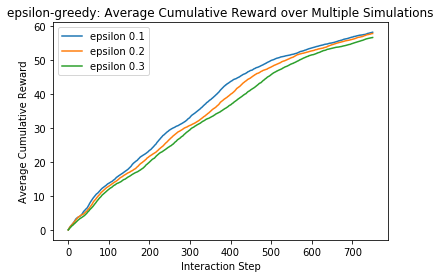

In [9]:
epsilons = [0.1,0.2,0.3]

num_simulations = 100

for epsilon in epsilons:
    
    all_runs = [] # stores cumulative rewards from each simulation
    
    for sim in range(num_simulations):
     
        eg = EpsilonGreedy(unique_arms, epsilon)

        total_interactions = 0
        total_rewards = 0

        num_interactions_per_user = 1  # <--- you can change this number

        # unique_users = train['user_id'].unique()
        unique_users = np.random.permutation(train['user_id'].unique())


        cum_reward =[]
        cur_step = 0

        for user_id in unique_users:
            for _ in range(num_interactions_per_user):
                chosen_movie = eg.select_arm()
                # Check if this user rated the chosen movie
                row = train[(train['user_id'] == user_id) & (train['movie_id'] == chosen_movie)]

                reward = 0
                if len(row) > 0:
                    rating = row.iloc[0]['rating']
                    reward = int(rating >= 4)
                    
                eg.update(chosen_movie, reward)
                total_rewards += reward
                total_interactions += 1

                cum_reward.append(total_rewards)
                
        all_runs.append(cum_reward)

            
    ave_cum_reward = np.mean(all_runs, axis=0)        
    plt.plot(ave_cum_reward, label=f'epsilon {epsilon}')

plt.title('epsilon-greedy: Average Cumulative Reward over Multiple Simulations')
plt.xlabel('Interaction Step')
plt.ylabel('Average Cumulative Reward')
plt.legend()
plt.show()